<a href="https://colab.research.google.com/github/astroChance/MPnet/blob/master/MPnet_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade segyio

     |████████████████████████████████| 92kB 2.4MB/s 


In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import time
import itertools
import os
import re
import random

In [8]:
### Data filenames

# 3D

Volume3D = "/content/drive/My Drive/MPnet/GAN data/3D/PB3D_Fritz_subset.sgy"

# 2D

TwoDFiles = []
for root, dirs, files in os.walk("/content/drive/My Drive/MPnet/GAN data/2D"):
    for name in files:
        filename = os.path.join(root, name)
        TwoDFiles.append(filename)
print("2D files in directory: ", len(TwoDFiles))

2D files in directory:  140


Example 2D line data shape:  (273, 3600)


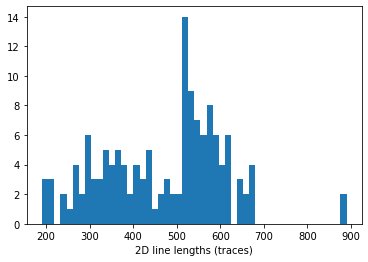


3D data shape: 


In [17]:
### Check geometry and line lengths of 2D files

with segyio.open(TwoDFiles[0], 'r', ignore_geometry=True) as line:
  Line = segyio.tools.collect(line.trace[:])
  print("Example 2D line data shape: ", Line.shape)

Zero_Ax = []

for radar_line in TwoDFiles:
  with segyio.open(radar_line, 'r', ignore_geometry=True) as line:
    Line = segyio.tools.collect(line.trace[:])
    Zero_Ax.append(Line.shape[0])
    One_Ax.append(Line.shape[1])

plt.hist(Zero_Ax, bins=50)
plt.xlabel("2D line lengths (traces)")
plt.show()




### Print geometry information for 3D cube

# with segyio.open(Volume3D, 'r', strict=False) as segyfile:
#   # cube = segyio.tools.cube(segyfile)    ### can't establish geometry
#   print("\n3D data shape: ")


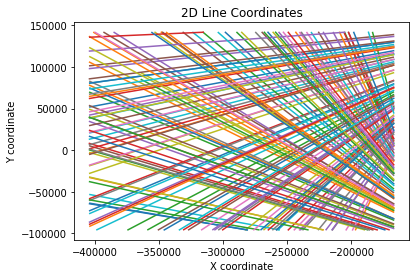

In [28]:
### Checl trace locations from 2D data

line_coords = {}
line_counter = 0
for radar_line in TwoDFiles:
  with segyio.open(radar_line, 'r', ignore_geometry=True) as line:
    x_vals=[]
    y_vals=[]
    for i in range(len(line.trace)):
      x_vals.append(line.header[i][segyio.TraceField.GroupX])
      y_vals.append(line.header[i][segyio.TraceField.GroupY])
    line_coords[line_counter] = {}
    line_coords[line_counter]['x_vals'] = x_vals
    line_coords[line_counter]['y_vals'] = y_vals
    line_counter += 1


for i in range(len(line_coords)):
  plt.plot(line_coords[i]['x_vals'], line_coords[i]['y_vals'])
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("2D Line Coordinates")
plt.show()

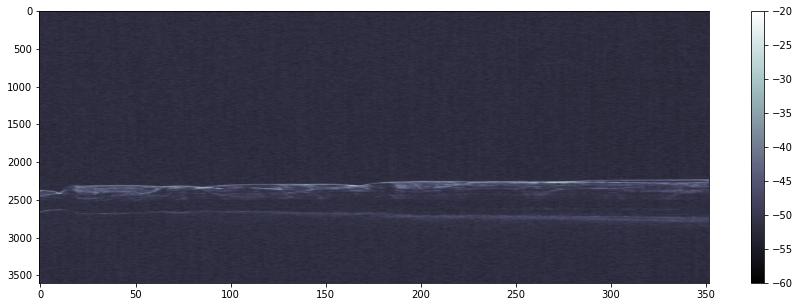

In [22]:
### Visual QC

# radar_file = TwoDFiles[0]
radar_file = random.choice(TwoDFiles)

with segyio.open(radar_file, 'r', ignore_geometry=True) as segyfile:
  display_line = segyio.tools.collect(segyfile.trace[:])

plt.figure(figsize=(15,5))
plt.imshow(display_line.T, cmap='bone', vmin = -60, vmax = -20, aspect='auto')
plt.colorbar()


In [ ]:
### Data QC
### Amplitude vaies on some 2D lines
### How does this compare to 3D
### Frequency spectra?
### Establish normalization parameters?

In [44]:
with segyio.open(Volume3D, 'r', ignore_geometry=True) as line:
  print(line.header[10])

{TRACE_SEQUENCE_LINE: 11, TRACE_SEQUENCE_FILE: 0, FieldRecord: 0, TraceNumber: 0, EnergySourcePoint: 0, CDP: 0, CDP_TRACE: 0, TraceIdentificationCode: 0, NSummedTraces: 0, NStackedTraces: 0, DataUse: 0, offset: 0, ReceiverGroupElevation: 0, SourceSurfaceElevation: 0, SourceDepth: 0, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 0, GroupWaterDepth: 0, ElevationScalar: 0, SourceGroupScalar: 0, SourceX: 0, SourceY: 0, GroupX: -404475, GroupY: -90975, CoordinateUnits: 0, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: 0, LagTimeB: 0, DelayRecordingTime: 0, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 0, TRACE_SAMPLE_INTERVAL: 0, GainType: 0, InstrumentGainConstant: 0, InstrumentInitialGain: 0, Correlated: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, SweepType: 0, SweepTraceTaperLengthStart: 0, SweepTraceTaperLen

In [36]:
"""
Design dictionary of:
{2D line number from filename : { 2D trace number : corresponding 3D trace number}
"""

# 3D coord dictionary
Trace_coords_3D = {}
with segyio.open(Volume3D, 'r',ignore_geometry=True) as segyfile:
  for i in range(len(segyfile.trace)):
    Trace_coords_3D[(segyfile.header[i][segyio.TraceField.GroupX], segyfile.header[i][segyio.TraceField.GroupY])] = segyfile.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE]

# 2D coordinate dictionary
Trace_coords_2D = {}
for radar_line in TwoDFiles:
  with segyio.open(radar_line, 'r', ignore_geometry=True) as line:
    line_num = os.path.basename(radar_line).split(".")[0]
    Trace_coords_2D[line_num] = {}

    for i in range(len(line.trace)):
      trace_2D = line.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE]
      x_2D = line.header[i][segyio.TraceField.GroupX]
      y_2D = line.header[i][segyio.TraceField.GroupY]

      ## Find 3D nearest neighbor for x and y
      ## minimize (dx + dy)

      for coord, trace_3D in Trace_coords_3D.items():
        x_3D, y_3D = coord



1192002000


In [54]:
## junk

# from collections import defaultdict

# my_dict = {}
# for i in range(3):
#   my_dict[i]=defaultdict(list)
#   for l in range(4):
#     for k in range(5):
#       my_dict[i][l].append(k)


# for key in my_dict:
#   # print(my_dict[key])
#   for i, j in my_dict[key].items():
#     print(key, i, j)

# print(my_dict)

#############

x = (1,2,3)

one, two, three = x
print(five)




NameError: ignored